Low-Dose CT (ADMM w/ Total Variation)
=====================================

This example demonstrates the use of class
[admm.ADMM](../_autosummary/scico.admm.rst#scico.admm.ADMM) to solve a
low-dose CT reconstruction problem with anisotropic total variation
(TV) regularization.

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_W^2 + \lambda \| C \mathbf{x} \|_1 \;,$$

where $A$ is the Radon transform, $\mathbf{y}$ is the sinogram, $C$ is
a 2D Finite Difference operator, and $\mathbf{x}$ is the desired
image.

The weighted norm is an approximation to the Poisson negative log
likelihood <cite data-cite="sauer-1993-local"/>.

In [1]:
import numpy as np

import jax

from xdesign import Soil, discrete_phantom

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot
from scico.admm import ADMM, LinearSubproblemSolver
from scico.linop.radon_astra import ParallelBeamProjector
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 512  # phantom size

np.random.seed(0)
x_gt = discrete_phantom(Soil(porosity=0.80), size=384)
x_gt = np.ascontiguousarray(np.pad(x_gt, (64, 64)))
x_gt = np.clip(x_gt, 0, np.inf)  # clip to positive values
x_gt = jax.device_put(x_gt)  # convert to jax type, push to GPU

Configure CT projection operator and generate synthetic measurements.

In [3]:
n_projection = 360  # number of projections
Io = 1e3  # source flux
𝛼 = 1e-2  # attenuation coefficient

angles = np.linspace(0, 2 * np.pi, n_projection)  # evenly spaced projection angles
A = ParallelBeamProjector(x_gt.shape, 1.0, N, angles)  # Radon transform operator
y_c = A @ x_gt  # sinogram

Add Poisson noise to projections according to

$$\mathrm{counts} \sim \mathrm{Poi}\left(I_0 exp\left\{- \alpha A
\mathbf{x} \right\}\right)$$

$$\mathbf{y} = - \frac{1}{\alpha} \log\left(\mathrm{counts} /
I_0\right).$$

We use the NumPy random functionality so we can generate using 64-bit
numbers.

In [4]:
counts = np.random.poisson(Io * snp.exp(-𝛼 * A @ x_gt))
counts = np.clip(counts, a_min=1, a_max=np.inf)  # replace any 0s count with 1
y = -1 / 𝛼 * np.log(counts / Io)
y = jax.device_put(y)  # convert back to float32

Setup post processing.  For this example, we clip all reconstructions
to the range of the ground truth.

In [5]:
def postprocess(x):
    return snp.clip(x, 0, snp.max(x_gt))

Compute an FBP reconstruction as an initial guess.

In [6]:
x0 = postprocess(A.fbp(y))

Set up and solve the un-weighted reconstruction problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_2^2 + \lambda \| C \mathbf{x} \|_1.$$

In [7]:
# Note that rho and lambda were selected via a parameter sweep (not
# shown here).
ρ = 2.5e3  # ADMM penalty parameter
lambda_unweighted = 2.56e2  # regularization strength

maxiter = 50  # number of ADMM iterations
max_inner_iter = 10  # number of CG iterations per ADMM iteration

f = loss.SquaredL2Loss(y=y, A=A)

admm_unweighted = ADMM(
    f=f,
    g_list=[lambda_unweighted * functional.L1Norm()],
    C_list=[linop.FiniteDifference(x_gt.shape)],
    rho_list=[ρ],
    x0=x0,
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"maxiter": max_inner_iter}),
    verbose=True,
)
admm_unweighted.solve()
x_unweighted = postprocess(admm_unweighted.x)

Iter  Time      Objective  Primal Rsdl  Dual Rsdl
-------------------------------------------------
   0  2.22e+00  2.444e+07    6.286e+01  1.298e+02


   1  3.42e+00  1.860e+07    1.854e+01  1.149e+02


   2  3.63e+00  1.370e+07    2.038e+01  9.751e+01
   3  3.82e+00  1.030e+07    1.965e+01  8.038e+01


   4  4.00e+00  8.001e+06    1.717e+01  6.543e+01
   5  4.20e+00  6.535e+06    1.509e+01  5.167e+01


   6  4.39e+00  5.711e+06    1.340e+01  3.821e+01
   7  4.57e+00  5.340e+06    1.154e+01  2.529e+01


   8  4.78e+00  5.222e+06    9.016e+00  1.477e+01


   9  4.98e+00  5.191e+06    6.045e+00  8.550e+00


  10  5.19e+00  5.197e+06    4.071e+00  5.078e+00
  11  5.37e+00  5.214e+06    2.888e+00  3.464e+00


  12  5.57e+00  5.229e+06    2.158e+00  2.808e+00
  13  5.75e+00  5.241e+06    1.747e+00  2.452e+00


  14  5.99e+00  5.250e+06    1.485e+00  2.179e+00
  15  6.18e+00  5.256e+06    1.298e+00  1.944e+00


  16  6.40e+00  5.261e+06    1.149e+00  1.739e+00


  17  6.66e+00  5.264e+06    1.035e+00  1.557e+00
  18  6.86e+00  5.266e+06    9.440e-01  1.394e+00


  19  7.05e+00  5.268e+06    8.661e-01  1.257e+00
  20  7.23e+00  5.270e+06    7.972e-01  1.143e+00


  21  7.43e+00  5.271e+06    7.376e-01  1.046e+00
  22  7.61e+00  5.272e+06    6.856e-01  9.627e-01


  23  7.81e+00  5.273e+06    6.398e-01  8.915e-01
  24  7.99e+00  5.274e+06    6.020e-01  8.297e-01


  25  8.15e+00  5.275e+06    5.686e-01  7.746e-01
  26  8.31e+00  5.276e+06    5.364e-01  7.259e-01


  27  8.50e+00  5.277e+06    5.084e-01  6.778e-01
  28  8.67e+00  5.278e+06    4.856e-01  6.315e-01


  29  8.84e+00  5.278e+06    4.632e-01  5.920e-01
  30  9.03e+00  5.279e+06    4.415e-01  5.546e-01


  31  9.19e+00  5.280e+06    4.238e-01  5.210e-01
  32  9.34e+00  5.281e+06    4.062e-01  4.917e-01


  33  9.53e+00  5.281e+06    3.899e-01  4.647e-01


  34  9.74e+00  5.282e+06    3.739e-01  4.426e-01
  35  9.90e+00  5.282e+06    3.595e-01  4.206e-01


  36  1.00e+01  5.283e+06    3.485e-01  4.026e-01
  37  1.02e+01  5.283e+06    3.362e-01  3.882e-01


  38  1.03e+01  5.284e+06    3.228e-01  3.601e-01
  39  1.04e+01  5.284e+06    3.158e-01  3.397e-01


  40  1.05e+01  5.285e+06    3.037e-01  3.342e-01
  41  1.06e+01  5.285e+06    2.938e-01  3.211e-01


  42  1.07e+01  5.285e+06    2.847e-01  3.079e-01
  43  1.09e+01  5.286e+06    2.765e-01  2.939e-01


  44  1.10e+01  5.286e+06    2.685e-01  2.817e-01
  45  1.11e+01  5.286e+06    2.611e-01  2.693e-01


  46  1.12e+01  5.287e+06    2.552e-01  2.595e-01
  47  1.14e+01  5.287e+06    2.477e-01  2.464e-01


  48  1.15e+01  5.287e+06    2.417e-01  2.383e-01
  49  1.16e+01  5.287e+06    2.356e-01  2.312e-01


Set up and solve the weighted reconstruction problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_W^2 + \lambda \| C \mathbf{x} \|_1 \;,$$

where

  $$W = \mathrm{diag}\left\{\exp( \sqrt{\mathbf{y}}) \right\}.$$

In [8]:
lambda_weighted = 1.14e2

weights = counts / Io  # scale by Io to balance the data vs regularization term
W = linop.Diagonal(snp.sqrt(weights))
f = loss.WeightedSquaredL2Loss(y=y, A=A, weight_op=W)

admm_weighted = ADMM(
    f=f,
    g_list=[lambda_weighted * functional.L1Norm()],
    C_list=[linop.FiniteDifference(x_gt.shape)],
    rho_list=[ρ],
    maxiter=maxiter,
    x0=x0,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"maxiter": max_inner_iter}),
    verbose=True,
)
admm_weighted.solve()
x_weighted = postprocess(admm_weighted.x)

Iter  Time      Objective  Primal Rsdl  Dual Rsdl
-------------------------------------------------
   0  8.87e-01  1.290e+07    2.944e+01  5.996e+01


   1  1.12e+00  1.143e+07    6.339e+00  5.757e+01
   2  1.30e+00  9.900e+06    6.132e+00  5.475e+01


   3  1.49e+00  8.509e+06    6.406e+00  5.156e+01
   4  1.68e+00  7.269e+06    6.494e+00  4.820e+01


   5  1.87e+00  6.181e+06    6.533e+00  4.471e+01
   6  2.05e+00  5.242e+06    6.392e+00  4.125e+01


   7  2.23e+00  4.438e+06    6.099e+00  3.792e+01


   8  2.45e+00  3.756e+06    5.798e+00  3.473e+01
   9  2.64e+00  3.181e+06    5.448e+00  3.171e+01


  10  2.81e+00  2.701e+06    5.148e+00  2.879e+01
  11  3.01e+00  2.305e+06    4.888e+00  2.596e+01


  12  3.20e+00  1.985e+06    4.610e+00  2.321e+01


  13  3.41e+00  1.733e+06    4.449e+00  2.039e+01
  14  3.60e+00  1.545e+06    4.251e+00  1.752e+01


  15  3.80e+00  1.410e+06    3.945e+00  1.470e+01


  16  4.01e+00  1.321e+06    3.649e+00  1.187e+01
  17  4.20e+00  1.268e+06    3.257e+00  9.170e+00


  18  4.39e+00  1.239e+06    2.733e+00  6.910e+00


  19  4.63e+00  1.225e+06    2.186e+00  5.185e+00
  20  4.83e+00  1.219e+06    1.730e+00  3.950e+00


  21  5.05e+00  1.216e+06    1.379e+00  3.036e+00


  22  5.28e+00  1.216e+06    1.158e+00  2.274e+00
  23  5.45e+00  1.216e+06    9.371e-01  1.737e+00


  24  6.03e+00  1.217e+06    7.478e-01  1.445e+00
  25  6.21e+00  1.217e+06    6.579e-01  1.200e+00


  26  6.39e+00  1.218e+06    5.540e-01  1.065e+00
  27  6.56e+00  1.218e+06    4.945e-01  9.669e-01


  28  6.74e+00  1.219e+06    4.480e-01  8.869e-01
  29  6.91e+00  1.219e+06    4.105e-01  8.197e-01


  30  7.10e+00  1.219e+06    3.802e-01  7.598e-01
  31  7.27e+00  1.219e+06    3.546e-01  7.093e-01


  32  7.45e+00  1.219e+06    3.296e-01  6.655e-01
  33  7.66e+00  1.219e+06    3.080e-01  6.257e-01


  34  7.82e+00  1.219e+06    2.892e-01  5.903e-01
  35  7.96e+00  1.219e+06    2.722e-01  5.592e-01


  36  8.10e+00  1.219e+06    2.588e-01  5.304e-01
  37  8.26e+00  1.220e+06    2.442e-01  5.077e-01


  38  8.43e+00  1.220e+06    2.314e-01  4.837e-01
  39  8.57e+00  1.220e+06    2.201e-01  4.608e-01


  40  8.74e+00  1.220e+06    2.095e-01  4.403e-01
  41  8.90e+00  1.220e+06    2.000e-01  4.212e-01


  42  9.04e+00  1.220e+06    1.923e-01  4.031e-01
  43  9.20e+00  1.220e+06    1.838e-01  3.867e-01


  44  1.22e+01  1.220e+06    1.769e-01  3.718e-01
  45  1.24e+01  1.220e+06    1.704e-01  3.591e-01


  46  1.25e+01  1.220e+06    1.634e-01  3.486e-01
  47  1.26e+01  1.220e+06    1.565e-01  3.379e-01


  48  1.28e+01  1.220e+06    1.508e-01  3.265e-01
  49  1.29e+01  1.220e+06    1.454e-01  3.160e-01


Show recovered images.

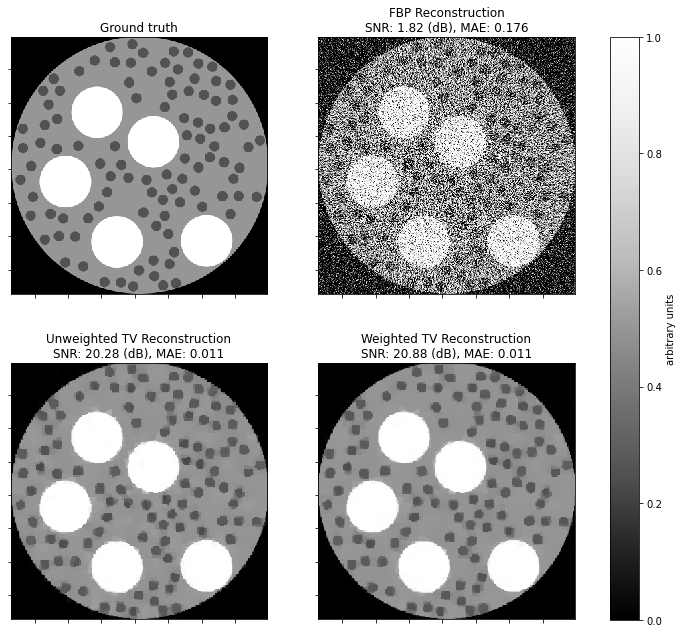

In [9]:
def plot_recon(x, title, ax):
    plot.imview(
        x,
        title=f"{title}\nSNR: {metric.snr(x_gt, x):.2f} (dB), MAE: {metric.mae(x_gt, x):.3f}",
        fig=fig,
        ax=ax,
    )


fig, ax = plot.subplots(nrows=2, ncols=2, figsize=(11, 10))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0])
plot_recon(x0, "FBP Reconstruction", ax=ax[0, 1])
plot_recon(x_unweighted, "Unweighted TV Reconstruction", ax=ax[1, 0])
plot_recon(x_weighted, "Weighted TV Reconstruction", ax=ax[1, 1])
for ax_ in ax.ravel():
    ax_.set_xlim(64, 448)
    ax_.set_ylim(64, 448)
fig.subplots_adjust(left=0.1, right=0.99, top=0.95, bottom=0.05, wspace=0.2, hspace=0.01)
fig.colorbar(
    ax[0, 0].get_images()[0], ax=ax, location="right", shrink=0.9, pad=0.05, label="arbitrary units"
)
fig.show()